In [1]:
import random as rand
import json
import cv2
from matplotlib import pyplot as plt
import albumentations as A
import os

In [2]:
PATH_TO_IMAGES = '/dih4/dih4_2/wimlds/data'
PATH_TO_ANN = '/dih4/dih4_2/wimlds/amikolajczyk/detect-waste/annotations/annotations_test.json'

In [3]:
with open(PATH_TO_ANN, 'r') as f:
        annotations = json.loads(f.read())

In [4]:
annotations['categories']

[{'category': 'metals_and_plastic',
  'id': 1,
  'name': 'metals_and_plastic',
  'supercategory': ''},
 {'category': 'other', 'id': 2, 'name': 'other', 'supercategory': ''},
 {'category': 'non_recyclable',
  'id': 3,
  'name': 'non_recyclable',
  'supercategory': ''},
 {'category': 'glass', 'id': 4, 'name': 'glass', 'supercategory': ''},
 {'category': 'paper', 'id': 5, 'name': 'paper', 'supercategory': ''},
 {'category': 'bio', 'id': 6, 'name': 'bio', 'supercategory': ''},
 {'category': 'unknown', 'id': 7, 'name': 'unknown', 'supercategory': ''}]

In [5]:
annotations.keys()

dict_keys(['annotations', 'categories', 'images', 'info', 'licenses'])

In [6]:
annotations['licenses']

[{'id': 0, 'name': '', 'url': ''}]

In [7]:
def rand_image(PATH_TO_IMAGES, annotations):
    im_id = rand.randint(0,len(annotations['images']))
    annotation, image = annotations['annotations'], annotations['images'][im_id]
    bboxes = [ann['bbox'] for ann in annotation if ann['image_id'] == image['id']]
    category_ids = [ann['category_id'] for ann in annotation if ann['image_id'] == image['id']]
    return image['file_name'], bboxes, category_ids

In [8]:
categories = annotations['categories']
category_id_to_name={}
for cat in categories:
    category_id_to_name[cat['id']] = cat['name']

In [9]:
BOX_COLOR = (255,0,0) # red
TEXT_COLOR = (255,255,255) # white
def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=4):
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    ((text_width, text_height), _) = cv2.getTextSize(class_name, FONT, 0.35,1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)),(x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text = class_name,
        org = (x_min, y_min - int(0.3 * text_height)),
        fontFace = FONT,
        fontScale = 0.35,
        color = TEXT_COLOR,
        lineType = cv2.LINE_AA,
        )
    
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    if isinstance(category_ids, list):
        for bbox, category_id in zip(bboxes, category_ids):
            class_name = category_id_to_name[category_id]
            img = visualize_bbox(img, bbox, class_name)
    else:
        class_name = category_id_to_name[category_ids]
        img = visualize_bbox(img, bboxes, class_name)
            
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(img)

# Visualize original annotations

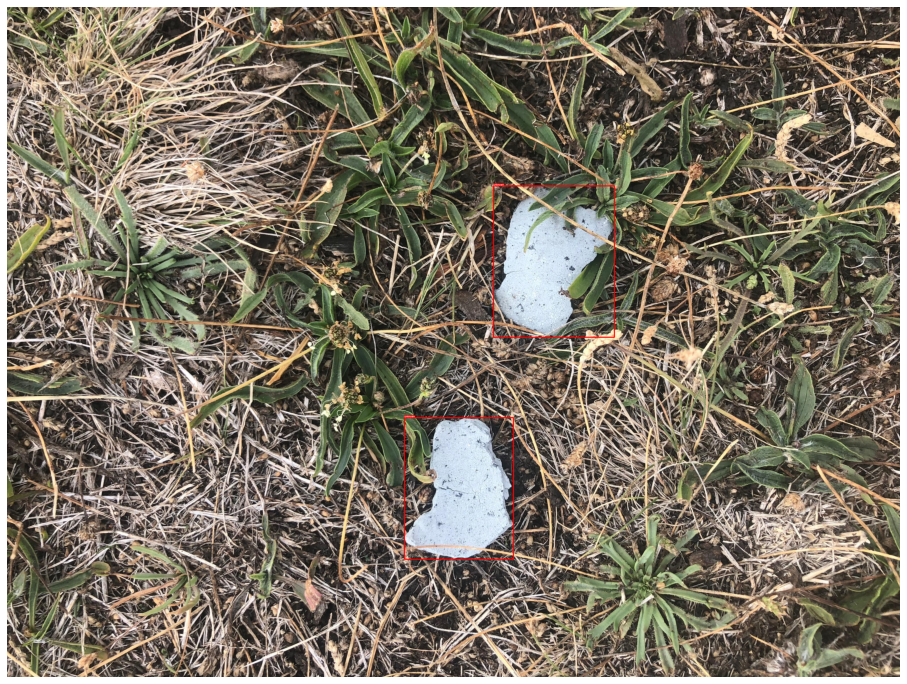

In [10]:
path_to_im, bbox, category_id = rand_image(PATH_TO_IMAGES, annotations)
image = cv2.imread(PATH_TO_IMAGES+'/'+path_to_im)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image, bbox, category_id, category_id_to_name)

# Visualize prediction results

In [11]:
# TO ADD RESULTS LIST YOUR DIRECTORIES WITH OUTPUTS
# os.listdir('/dih4/dih4_2/wimlds/smajchrowska/output/train/')

# Set parameters
TYPE = 'Multi'
threshold = .4  # set threshold for probability

In [12]:
import sys
# add modules from efficiendet path
sys.path.append('../')

import torch.nn.parallel
from contextlib import suppress

from effdet import create_model, create_evaluator, create_dataset, create_loader
from effdet.data import resolve_input_config
from effdet.evaluator import CocoEvaluator, PascalEvaluator
from timm.utils import AverageMeter, setup_default_logging

if TYPE == 'DetectWaste7':
    CH_PATH = '/dih4/dih4_2/wimlds/amikolajczyk/detect-waste/output/train/20201221-212419-tf_efficientdet_d2/model_best.pth.tar'
    CLASSES = ['metals_and_plastic', 'other', 'non_recyclable', 'glass',  'paper',  'bio', 'unknown']
elif TYPE == 'Multi':
    CH_PATH = '/dih4/dih4_2/wimlds/smajchrowska/output/train/20210130-231654-tf_efficientdet_d2/model_best.pth.tar'
    CLASSES = ['Litter']
elif TYPE == 'icra_coco':
    CH_PATH = '/dih4/dih4_2/wimlds/smajchrowska/output/train/20210130-103847-tf_efficientdet_d2/model_best.pth.tar'
    CLASSES = ['plastic', 'paper', 'unknown', 'cloth', 'rubber', 'metal', 'wood']
elif TYPE == 'drink-waste':
    CH_PATH = '/dih4/dih4_2/wimlds/smajchrowska/output/train/20210129-212456-tf_efficientdet_d2/model_best.pth.tar'
    CLASSES = ['AluCan', 'Glass', 'HDPEM', 'PET']
elif TYPE == 'TrashCan':
    CH_PATH = '/dih4/dih4_2/wimlds/smajchrowska/output/train/20210129-204736-tf_efficientdet_d2/model_best.pth.tar'
    CLASSES = ['trash_etc', 'trash_fabric', 'trash_fishing_gear','trash_metal',
           'trash_paper','trash_plastic', 'trash_rubber','trash_wood']
elif TYPE == 'mju-waste':
    CH_PATH = '/dih4/dih4_2/wimlds/smajchrowska/output/train/20210130-101501-tf_efficientdet_d2/model_best.pth.tar'
    CLASSES = ['Litter']
elif TYPE == 'wade-ai':
    CH_PATH = '/dih4/dih4_2/wimlds/smajchrowska/output/train/20210130-102812-tf_efficientdet_d2/model_best.pth.tar'
    CLASSES = ['Litter'] 
elif TYPE == 'uavvaste':
    CH_PATH = '/dih4/dih4_2/wimlds/smajchrowska/output/train/20210130-101136-tf_efficientdet_d2/model_best.pth.tar'
    CLASSES = ['Litter'] 

num_classes = len(CLASSES)
print(CH_PATH)
model = CH_PATH.split('-')[-1].split('/')[0]
# create model
bench = create_model(
    model,
    bench_task='predict',
    num_classes=num_classes,
    pretrained=False,
    redundant_bias=True,
    checkpoint_path=CH_PATH
)
model_config = bench.config

param_count = sum([m.numel() for m in bench.parameters()])
print('Model %s created, param count: %d' % (model, param_count))

bench = bench.to('cpu')
bench.eval()

/dih4/dih4_2/wimlds/smajchrowska/output/train/20210130-231654-tf_efficientdet_d2/model_best.pth.tar
Model tf_efficientdet_d2 created, param count: 8006526


DetBenchPredict(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SiLU(inplace=True)
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps=

In [13]:
from PIL import Image
import torchvision.transforms as T
import torch
torch.set_grad_enabled(False);

from effdet.data.transforms import *
import numpy as np
import matplotlib.pyplot as plt

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize((768, 768)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

if TYPE == 'DetectWaste7':
    img_name = '/dih4/dih4_2/wimlds/smajchrowska/TACO_split/val/000344.jpg'
    img_name = '/dih4/dih4_2/wimlds/smajchrowska/TACO_split/val/001290.jpg'
    img_name = '/dih4/dih4_2/wimlds/smajchrowska/TACO_split/val/000069.jpg'
    img_name = '/dih4/dih4_2/wimlds/smajchrowska/TACO_split/val/001203.jpg'
elif TYPE == 'Multi':
    img_name = '/dih4/dih4_2/wimlds/data/all_detect_images/batch_8/000037.jpg' # glass
    img_name = '/dih4/dih4_2/wimlds/data/all_detect_images/batch_14/000081.jpg' # glass
    img_name = '/dih4/dih4_2/wimlds/data/all_detect_images/dumped/99toMesVaOHKd8lOIZBVKS1MDPlXSPkTmdijxfiO.jpeg' # wszystko
    # img_name = 'https://www.fyidenmark.com/images/denmark-litter.jpg'
elif TYPE == 'drink-waste':
    # drink-waste
    img_name = '/dih4/dih4_2/wimlds/data/drinking-waste/YOLO_imgs/mix5.jpg'
elif TYPE == 'mju-waste':
    # mju-waste
    img_name = '/dih4/dih4_2/wimlds/data/mju-waste-v1/JPEGImages/2019-09-19_16_20_17-93_color.png'
elif TYPE == 'uavvaste':
    # drone dataset
    img_name = '/dih4/dih4_2/wimlds/data/uavvaste/images/batch_03_img_3120.jpg'
    # Wada-AI
    img_name = '/dih4/dih4_2/wimlds/data/wade-ai/wade-ai_images/0b62d36a-763c-4d55-84c1-488a9516ffad_02471439-08f6-4915-b0c6-9a8065bf8b85.jpg' # wade-ai
elif TYPE == 'TrashCan':
    # TrashCan
    img_name = '/dih4/dih4_2/wimlds/data/TrashCan_v1/material_version/val/vid_000291_frame0000065.jpg'
    img_name = '/dih4/dih4_2/wimlds/data/TrashCan_v1/material_version/val/vid_000112_frame0000050.jpg'
elif TYPE == 'icra_coco':
    # ICRA
    img_name = '/dih4/dih4_2/wimlds/data/trash_icra/trash_ICRA19/dataset/val/obj0029_frame0000025.jpg'

In [14]:
# read an image
if img_name.startswith('https'):
    import requests
    im = Image.open(requests.get(img_name, stream=True).raw).convert('RGB')
else:
    im = Image.open(img_name).convert('RGB')

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = bench(img)

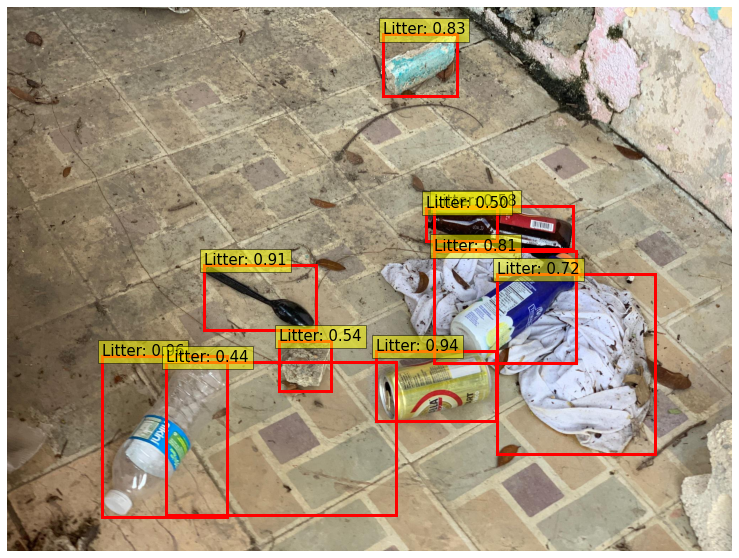

In [15]:
plt.figure(figsize=(16,10))
#imga = im.resize((768, 768), Image.ANTIALIAS)
plt.imshow(im)
w, h = im.size
ax = plt.gca()

for i in outputs[0, outputs[0, :, 4] > threshold].tolist():
    scale_w = w/768
    scale_h = h/768
    i[0] *= scale_w
    i[1] *= scale_h
    i[2] *= scale_w
    i[3] *= scale_h
    p = np.array(i[4:-1])
    ax.add_patch(plt.Rectangle((i[0], i[1]), i[2] - i[0], i[3] - i[1],
                                   fill=False, color='r', linewidth=3))
    cl = int(i[-1])-1
    text = f'{CLASSES[cl]}: {p[0]:0.2f}'
    ax.text(i[0], i[1], text, fontsize=15,
            bbox=dict(facecolor='yellow', alpha=0.5))
plt.axis('off')
plt.show()